In [323]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.optimize import differential_evolution   
import matplotlib.pylab as plt
from matplotlib.pyplot import savefig
from matplotlib.lines import Line2D
from scipy.integrate import solve_ivp
import pandas as pd
import math 
from datetime import date
from scipy.integrate import solve_ivp
import sys
import os
import copy 

In [272]:
# Reading data
df = pd.read_csv("Tumor_lengths.csv")
df = df.loc[~df['ID'].isin(['A1001','A1003', 'A1015', 'E1034'])] # A1001,A1002,A1015 and E1034 have 4 or fewer data points
df = df[~((df['ID'] == 'A1009') & (df['sum_tumor_lengths'] == 10))] 
#remove the last point (10mm)as it is a single lymph node 5 days after previous scan -add to previous instead)
# Add 10 to the value at row 68 and column 1 as dates should be combined
df.iloc[68, 1] = df.iloc[68, 1] + 10
df.iloc[68,2] = df.iloc[68,2] + 167 


df_anyue = pd.read_excel("Individual parameters_START_TKI patients_AYin.xlsx")
df_anyue = df_anyue[["PID","PD_Kg(/day)","PD_Kd(/day)","PD_Km(/day)"]]
df_anyue = df_anyue.rename(columns={"PID": "ID", "PD_Kg(/day)": "kg", "PD_Kd(/day)": "kd", "PD_Km(/day)": "km"})
df_anyue = df_anyue.loc[~df_anyue['ID'].isin(['A1001','A1003', 'A1015', 'E1034'])] # A1001,A1003,A1015 and E1034 have 4 or fewer data points
cols = df_anyue.columns.tolist()
cols[2],cols[3]=cols[3],cols[2] # swap kd and km so anyue's columns match ours
df_anyue = df_anyue[cols]




In [273]:
df.iloc[:,1]
print(df.iloc[55:69,:])


    days  sum_tumor_lengths  Sum_tumor_volume     ID
63     0               91.0      18055.166667  A1009
64    67               50.0       5253.333333  A1009
65   109               42.0       3773.000000  A1009
66   151               42.0       3773.000000  A1009
67   193               49.0       7260.166667  A1009
68   230               49.0       7260.166667  A1009
70     0               66.0       3912.000000  A1011
71    57               39.0       1150.500000  A1011
72   139               20.0        115.333333  A1011
73   181               13.0         93.166667  A1011
74   221               13.0         93.166667  A1011
75     0               88.0      15994.666667  A1012
76    75               59.0       8896.833333  A1012
77   116               80.0       7248.666667  A1012


In [274]:
# Logistic population model
def system_ode_logistic(time, populations, params):
    Spop = populations[0]
    Rpop = populations[1]
    r = params[0] #growth rate
    kmax = params[1] #carrying capacity
    kd = params[2] #death rate due to medication

    days = time

    dSpop_dt = Spop * (r * (1- (Spop + Rpop)/kmax) - kd)
    dRpop_dt = Rpop * (r * (1- (Spop + Rpop)/kmax))
    return [dSpop_dt, dRpop_dt]

# Cost function
def cost_func_logistic(params, time, data):
    initial_populations = params[3:]
    tspan = [days[0], days[-1]]
    
    pred_data_log = solve_ivp(system_ode_logistic, tspan, initial_populations, 
                             t_eval = np.ravel(days), args = tuple([params[:3]]))
    
    if pred_data_log.y.shape[1] == np.ravel(days).shape[0]:
        spop = pred_data_log.y[0]
        rpop = pred_data_log.y[1]
        sum_pops = spop + rpop
        sumsq_error = np.sum((sum_pops - data)**2)
        msq_error = sumsq_error/len(data)
        mean_abs_error = (np.sum(np.abs(sum_pops-data)))/len(data)
        #rmse = np.sqrt(msq_error)
    else: 
        msq_error = 1e30
        #rmse = 1e30


    return msq_error


##### Fitting logistic model

In [308]:
unique_IDs = df.ID.unique()
master_dictionary = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    print("Working on patient:", id, " Number of data points:", len(days))

# fitting patient data to equations (r,Kmax,kd,spop,rpop)
    #bounds = [(1e-2, 2e-1), (data[0], 1000), (1e-2, 1e-1),(0, data[0]), (0, 3*data[0])]
    #init_params = [5e-2, 3*data[0],2e-2, data[0]-1e-3, 1e-3]  
    bounds = [(2e-2, 2e-1), (data[0], 120), (1e-2, 1e-1),(0, data[0]), (0, 3*data[0])]
    init_params = [5e-2, data[0],5e-2, data[0]-1e-3, 1e-3]
    opt_result_log = minimize(cost_func_logistic, init_params, 
                              args=(days, data), bounds = bounds, method="nelder-mead")
    # store the optimal parameters and the cost function value (last entry in list)
    master_dictionary[id] = opt_result_log.x.tolist() + [opt_result_log.fun] 


Working on patient: A1002  Number of data points: 16
Working on patient: A1004  Number of data points: 5
Working on patient: A1006  Number of data points: 9
Working on patient: A1007  Number of data points: 13
Working on patient: A1008  Number of data points: 12
Working on patient: A1009  Number of data points: 6
Working on patient: A1011  Number of data points: 5
Working on patient: A1012  Number of data points: 10
Working on patient: A1013  Number of data points: 7
Working on patient: A1014  Number of data points: 18
Working on patient: A1016  Number of data points: 14
Working on patient: A1017  Number of data points: 7
Working on patient: E1008  Number of data points: 6
Working on patient: E1012  Number of data points: 16


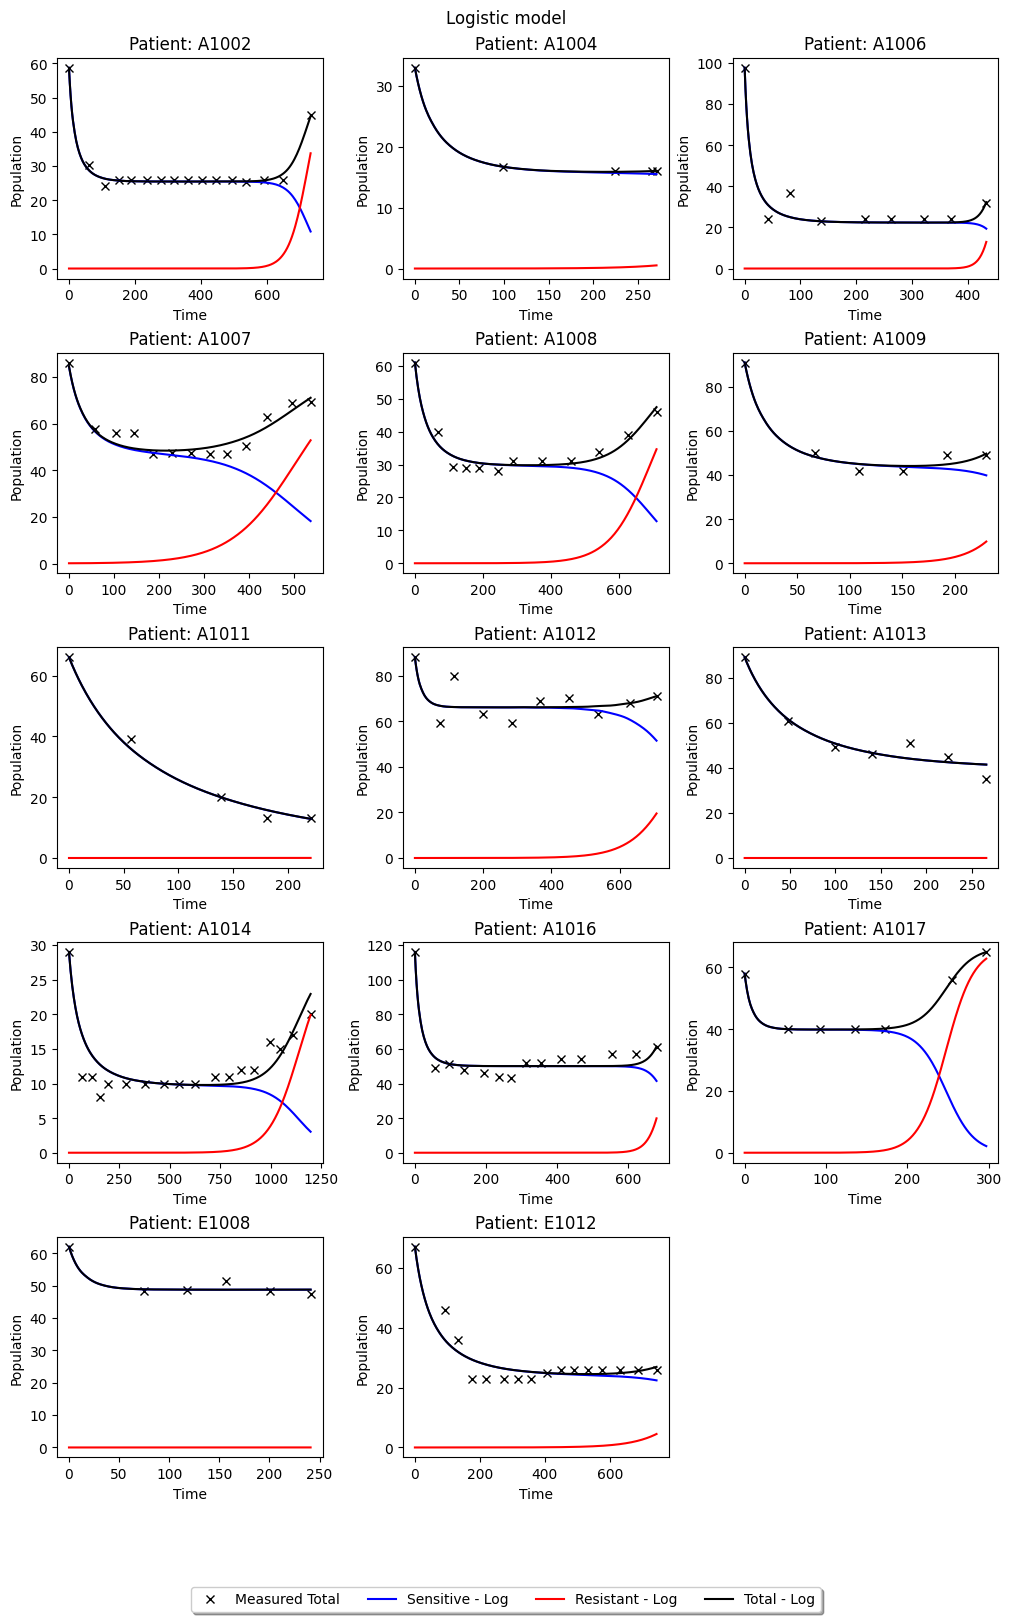

In [309]:
# setting up subplots   
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_log = master_dictionary[id]
    init_populations_log = optimal_params_log[3:-1]

    pred_data_log = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:3]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Log'),
                   Line2D([0], [0], color='r', label='Resistant - Log'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Log'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Logistic model')  
plt.show()

In [307]:
df_log2 = pd.DataFrame.from_dict(master_dictionary, orient='index', 
                                     columns=['r','Kmax','kd','spop_0','rpop_0','mse'])
df_log2

,r,Kmax,kd,spop_0,rpop_0,mse
A1002,0.061286,58.700000,0.034726,58.693515,1.762360e-09,0.861789
A1004,0.046590,33.000000,0.024346,32.999957,1.515331e-03,0.002761
A1006,0.107283,97.600000,0.082726,97.600000,3.534398e-14,21.519270
A1007,0.030435,86.200000,0.013796,84.483318,1.482066e-01,11.685892
A1008,0.031956,61.000000,0.016439,61.000000,1.389997e-03,4.089588
A1009,0.040402,92.939496,0.023112,89.718710,2.420554e-01,4.110795
A1011,0.020000,200.000000,0.024973,66.000000,8.132132e-03,1.654663
A1012,0.059202,88.000000,0.014757,88.000000,9.714274e-04,34.254450
A1013,0.020729,89.000000,0.011556,88.999945,1.223948e-03,14.398380
A1014,0.020000,29.000000,0.013327,28.999211,2.250092e-05,5.806086


##### logistic with DE

In [363]:
from scipy.optimize import differential_evolution
unique_IDs = df.ID.unique()
master_dictionary = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    max_value = max(data[0], data[-1])

    print("Working on patient:", id, " Number of data points:", len(days))
    #bounds = [(3e-2, 3e-1), (1.1*max_value, 2*max_value), (1e-2, 1e-1),(0, data[0]), (0, 3*data[0])] # r, K, kd, spop, rpop
    bounds = [(5e-3, 3e-1), (1.1*max_value, 2*max_value), (1e-2, 1e-1),(0, data[0]), (0, 3*data[0])] # r, K, kd, spop, rpop


    # Use differential_evolution to perform a random search
    opt_result_log = differential_evolution(cost_func_logistic, bounds, args=(days, data))
    # store the optimal parameters and the cost function value (last entry in list)
    master_dictionary[id] = opt_result_log.x.tolist() + [opt_result_log.fun]

Working on patient: A1002  Number of data points: 16
Working on patient: A1004  Number of data points: 5
Working on patient: A1006  Number of data points: 9
Working on patient: A1007  Number of data points: 13
Working on patient: A1008  Number of data points: 12
Working on patient: A1009  Number of data points: 6
Working on patient: A1011  Number of data points: 5
Working on patient: A1012  Number of data points: 10
Working on patient: A1013  Number of data points: 7
Working on patient: A1014  Number of data points: 18
Working on patient: A1016  Number of data points: 14
Working on patient: A1017  Number of data points: 7
Working on patient: E1008  Number of data points: 6
Working on patient: E1012  Number of data points: 16


In [360]:
df_log2 = pd.DataFrame.from_dict(master_dictionary, orient='index', 
                                     columns=['r','Kmax','kd','spop_0','rpop_0','mse'])
df_log2

,r,Kmax,kd,spop_0,rpop_0,mse
A1002,0.065696,68.309574,0.041025,58.644348,1.463718e-11,0.594936
A1004,0.056833,36.302761,0.031847,32.999949,2.062183e-05,0.000001
A1006,0.106749,107.365879,0.082897,97.319385,2.661717e-14,20.556352
A1007,0.030000,94.951954,0.015026,86.188020,6.359522e-02,10.440990
A1008,0.030000,67.100000,0.016832,60.978822,8.559753e-04,4.914851
A1009,0.030995,100.276803,0.020582,90.395871,6.897101e-01,4.015577
A1011,0.030000,131.969913,0.030825,66.000000,0.000000e+00,6.472851
A1012,0.070772,97.332283,0.022638,87.469987,2.648453e-06,34.045349
A1013,0.030189,130.195735,0.021067,88.833892,4.963209e-05,14.389776
A1014,0.030971,31.904401,0.020515,27.702546,2.403009e-09,5.694574


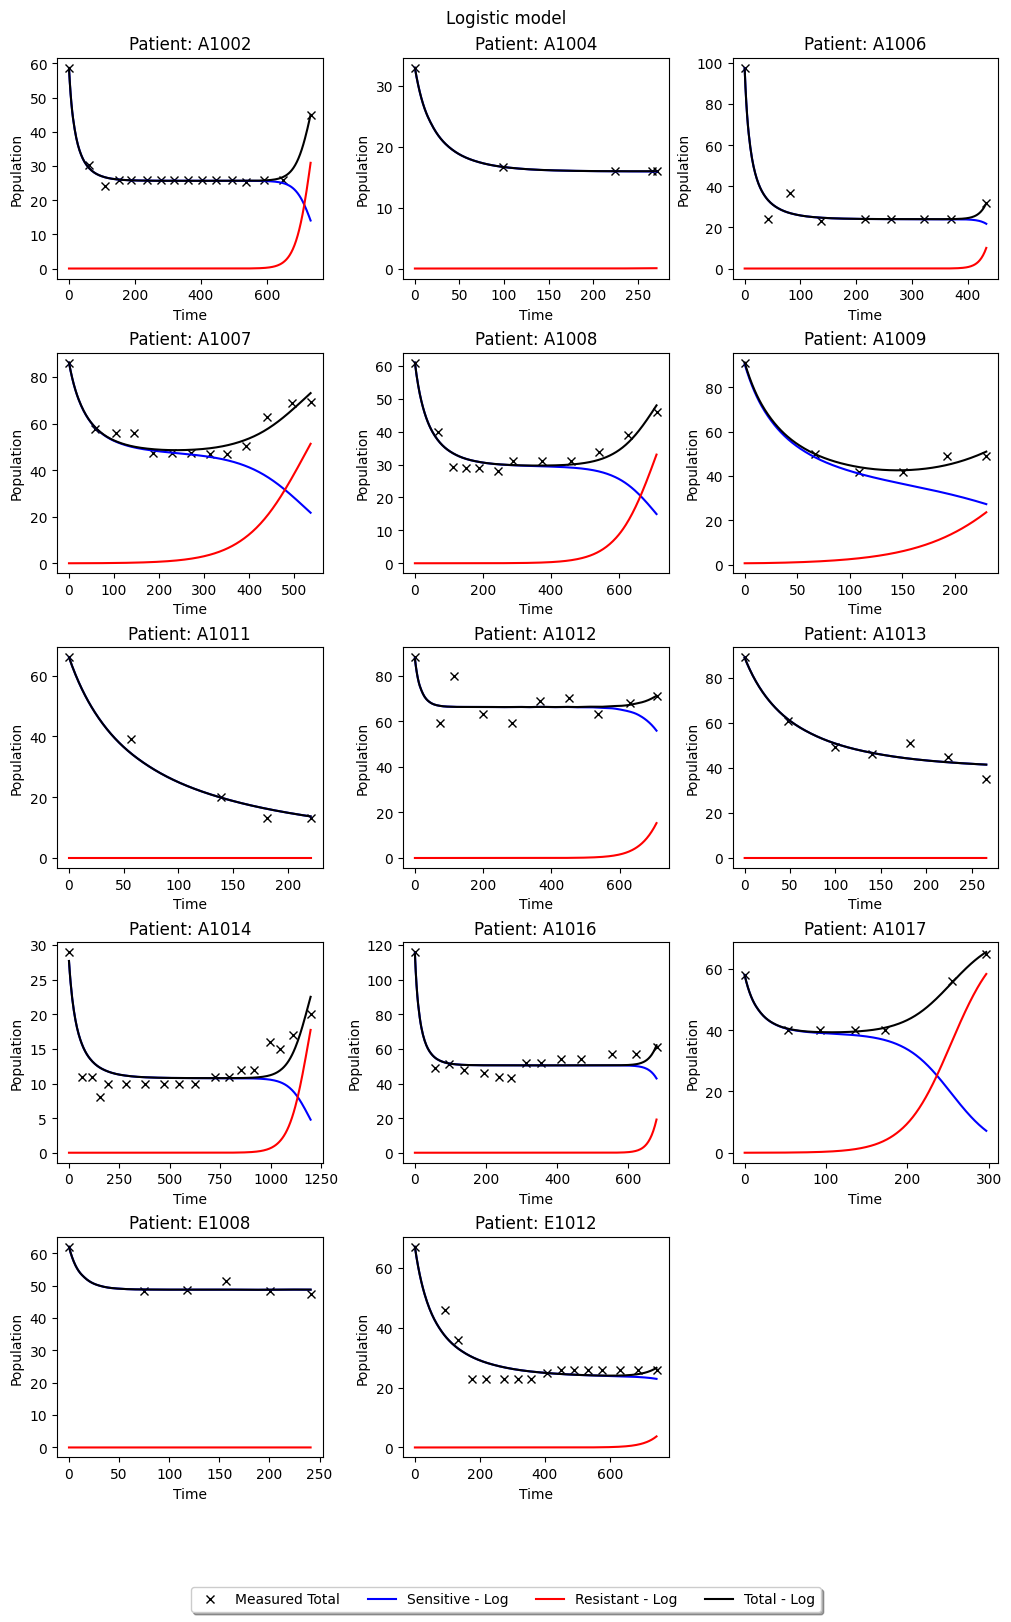

In [359]:
# setting up subplots   
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_log = master_dictionary[id]
    init_populations_log = optimal_params_log[3:-1]

    pred_data_log = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:3]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Log'),
                   Line2D([0], [0], color='r', label='Resistant - Log'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Log'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Logistic model')  
plt.show()

##### Logistic DE MTD vs 1/2 MTD

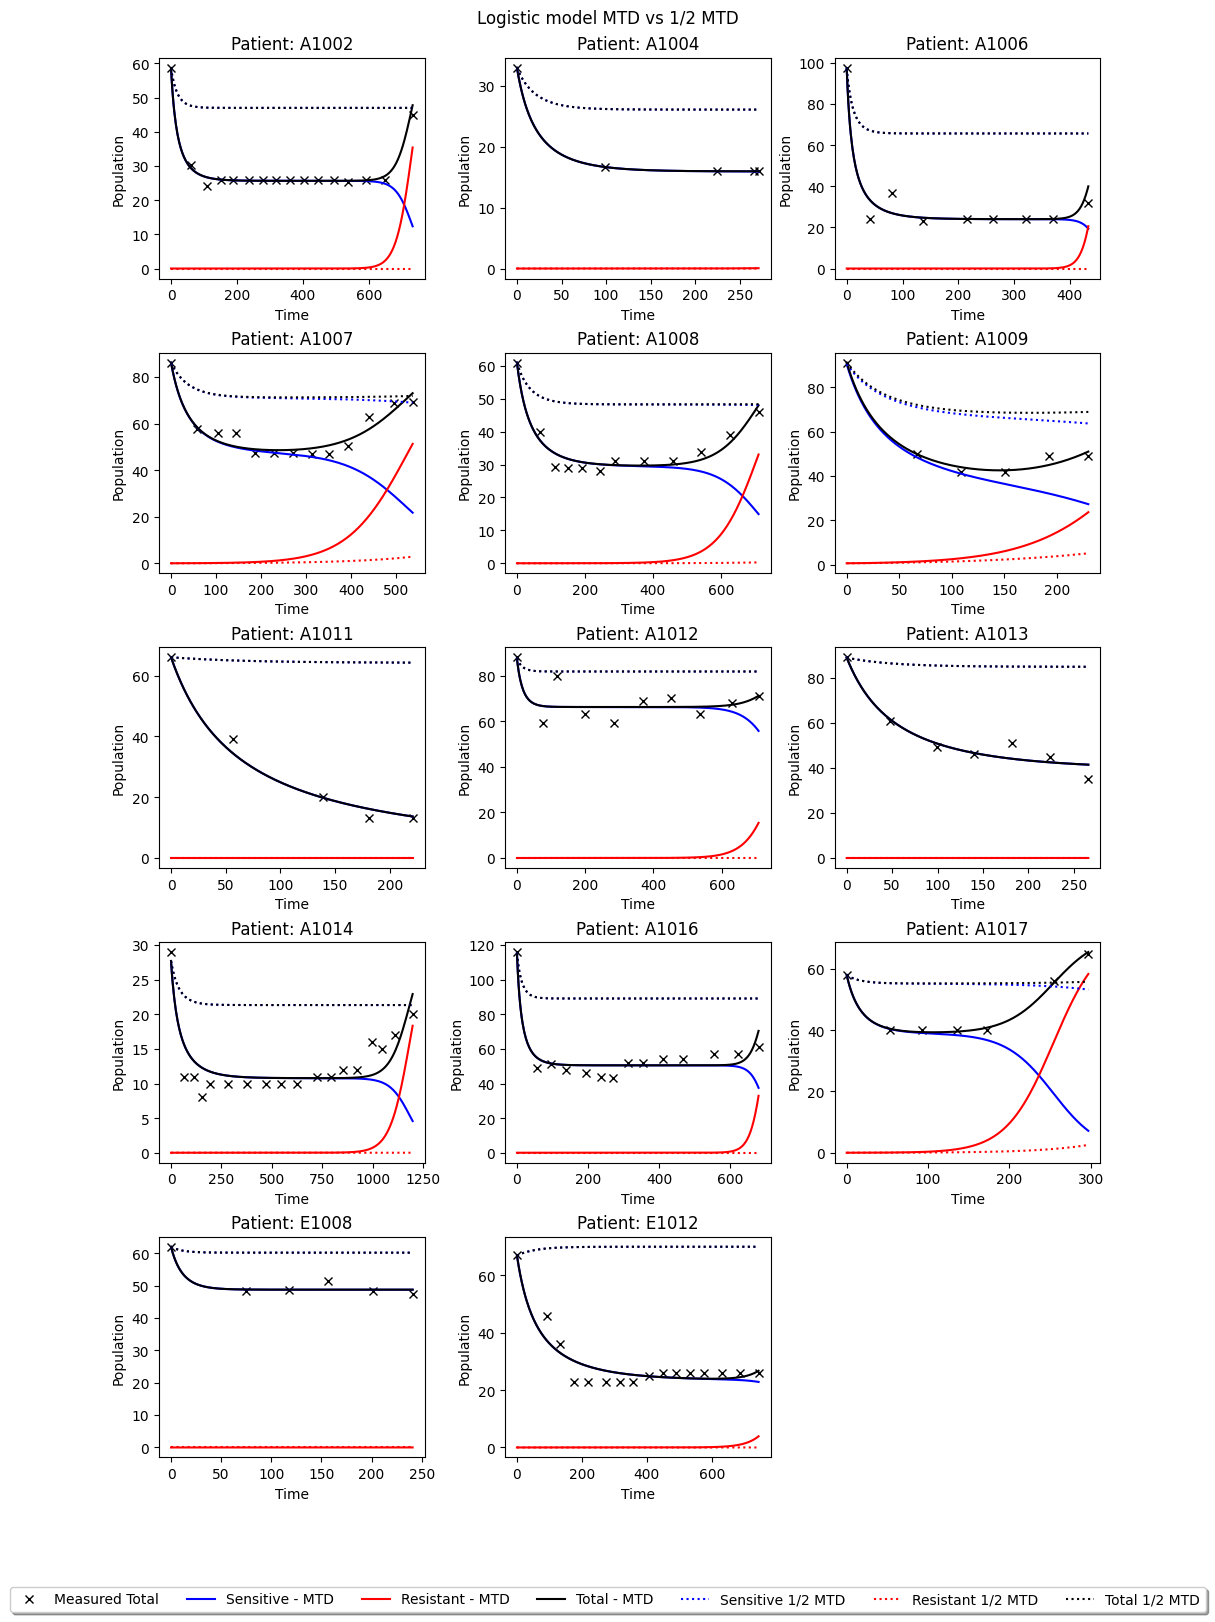

In [357]:
# Make a deep copy of master_dictionary to change medication parameters in

master_dictionary_copy = copy.deepcopy(master_dictionary) # deep to create a copy that can be changed
for key in master_dictionary_copy:
    master_dictionary_copy[key][2] *= 0.5

# setting up subplots   
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# fitting data for parameters with half medication
for index, id in enumerate(unique_IDs, start=0):
    
    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    ### optimal params original medication 
    optimal_params_log = master_dictionary[id]
    init_populations_log = optimal_params_log[3:-1]

    pred_data_log = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_log, dense_output=True, max_step=1e-2,
                            args = tuple([optimal_params_log[:3]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

    ### optimal params 1/2 medication
    optimal_params_log_half = master_dictionary_copy[id] # use parameters with 1/2 medication
    init_populations_log_half = optimal_params_log_half[3:-1]

    pred_data_log_half = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_log_half, dense_output=True, max_step = 1e-2,
                            args = tuple([optimal_params_log_half[:3]]))
    sum_pops_log_half = np.sum(pred_data_log_half.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    ax.plot(days, data, 'kx', label='Measured Total') 
    # plot with full medication
    ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')

    # plot with half medication
    ax.plot(tspan, pred_data_log_half.sol(tspan)[0], 'b:', label='Sensitive - Log') 
    ax.plot(tspan, pred_data_log_half.sol(tspan)[1], 'r:', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log_half, 'k:', label='Total - Log')

    #set axis labels
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - MTD'),
                   Line2D([0], [0], color='r', label='Resistant - MTD'),
                   Line2D([0], [0], color='k',label='Total - MTD'),
                   Line2D([0], [0], color='b', linestyle=':', label='Sensitive 1/2 MTD'),
                   Line2D([0], [0], color='r', linestyle=':', label='Resistant 1/2 MTD'),
                   Line2D([0], [0], color='k', linestyle= ':' ,label='Total 1/2 MTD')]


fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Logistic model MTD vs 1/2 MTD')  
plt.show()

##### Extending time MTD vs 1/2 MTD logistic

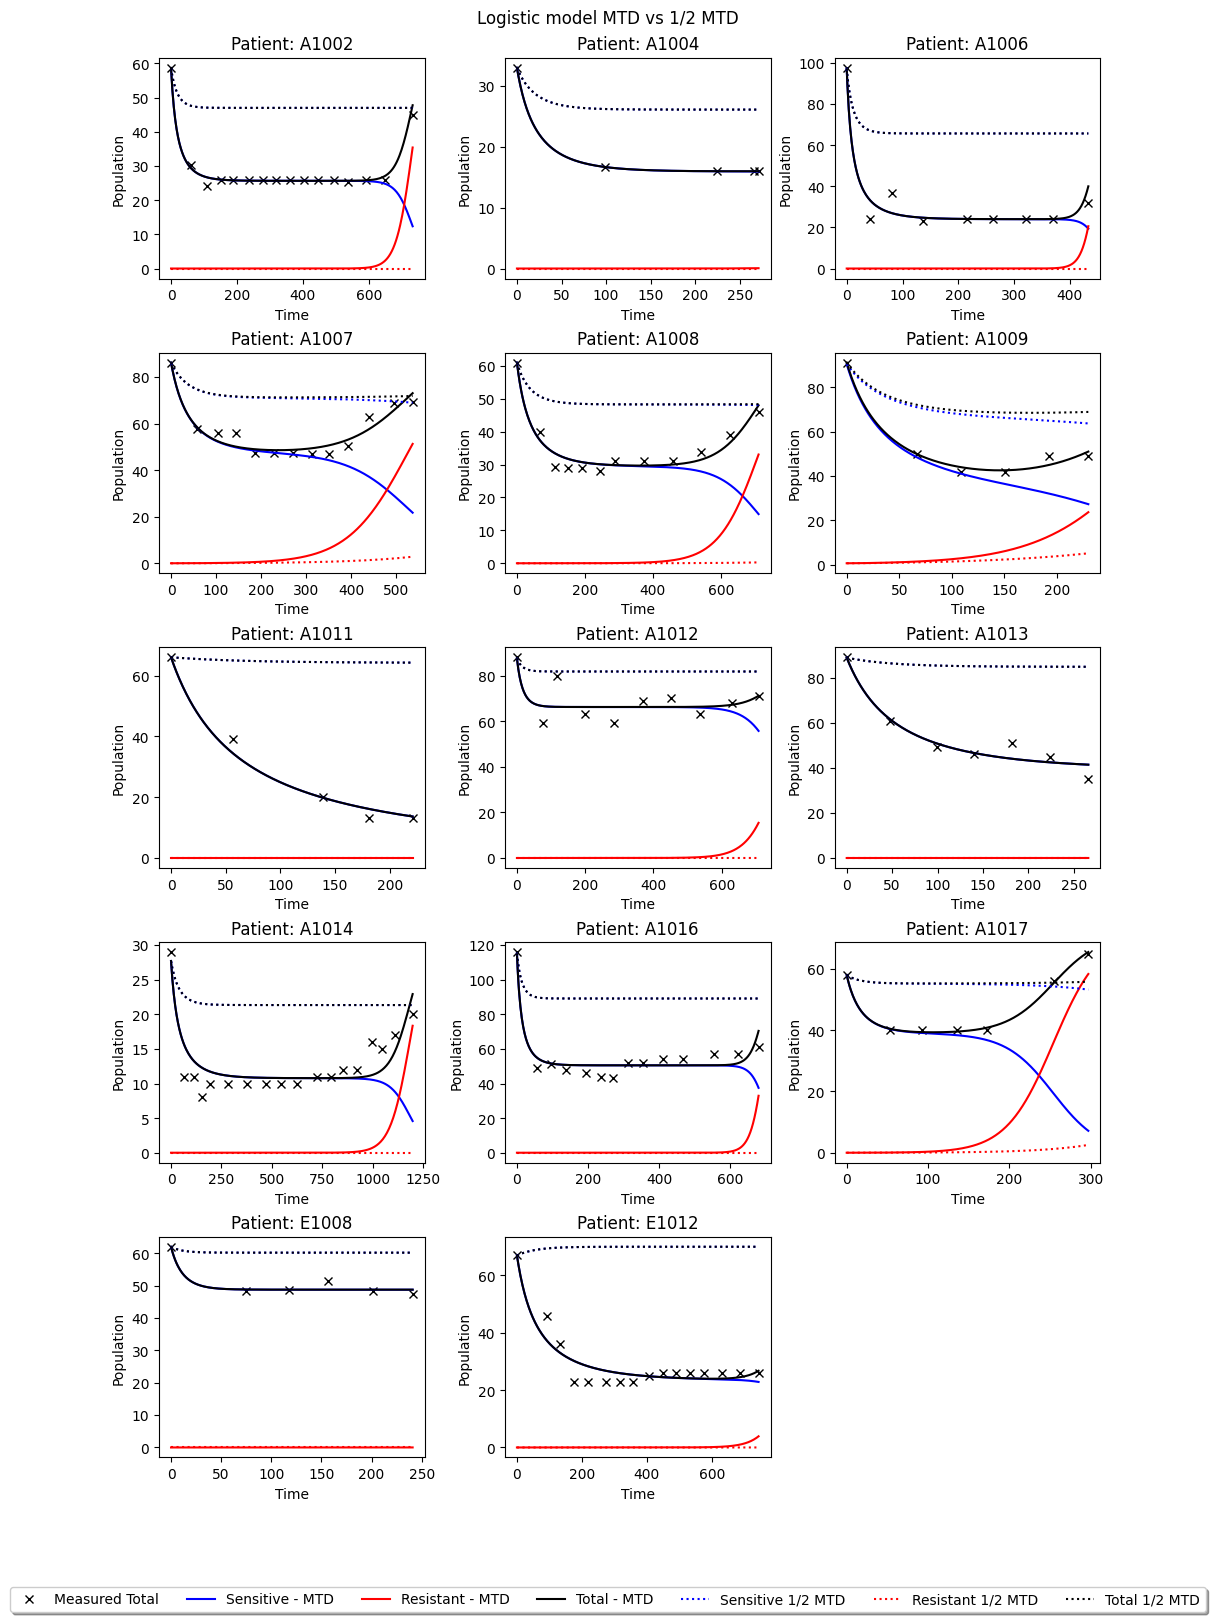

In [362]:
# Make a deep copy of master_dictionary to change medication parameters in

master_dictionary_copy = copy.deepcopy(master_dictionary) # deep to create a copy that can be changed
for key in master_dictionary_copy:
    master_dictionary_copy[key][2] *= 0.5

# setting up subplots   
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# fitting data for parameters with half medication
for index, id in enumerate(unique_IDs, start=0):
    
    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    ### optimal params original medication 
    optimal_params_log = master_dictionary[id]
    init_populations_log = optimal_params_log[3:-1]

    pred_data_log = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_log, dense_output=True, max_step=1e-3,
                            args = tuple([optimal_params_log[:3]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

    ### optimal params 1/2 medication
    optimal_params_log_half = master_dictionary_copy[id] 
    init_populations_log_half = optimal_params_log_half[3:-1]

    pred_data_log_half = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_log_half, dense_output=True, max_step = 1e-2,
                            args = tuple([optimal_params_log_half[:3]]))
    sum_pops_log_half = np.sum(pred_data_log_half.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    ax.plot(days, data, 'kx', label='Measured Total') 
    # plot with full medication
    ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')

    # plot with half medication
    ax.plot(tspan, pred_data_log_half.sol(tspan)[0], 'b:', label='Sensitive - Log') 
    ax.plot(tspan, pred_data_log_half.sol(tspan)[1], 'r:', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log_half, 'k:', label='Total - Log')

    #set axis labels
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - MTD'),
                   Line2D([0], [0], color='r', label='Resistant - MTD'),
                   Line2D([0], [0], color='k',label='Total - MTD'),
                   Line2D([0], [0], color='b', linestyle=':', label='Sensitive 1/2 MTD'),
                   Line2D([0], [0], color='r', linestyle=':', label='Resistant 1/2 MTD'),
                   Line2D([0], [0], color='k', linestyle= ':' ,label='Total 1/2 MTD')]


fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Logistic model MTD vs 1/2 MTD')  
plt.show()